plot the primary forest conversion to different land cover types

In [1]:

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import pandas as pd
import matplotlib.ticker as plticker
import seaborn as sns
import os


def plot_pf_annual_conversion_stacked(df_pf_lc_count, plot_type='single',
                                      x_label=None, y_label=None, title=None,):
    """
        stacked plot to show the primary forest conversion

        Args:
            df_pf_lc_count: Dataframe
    """

    # sns.set_style('white')
    sns.set_theme()
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(20, 12))

    legend_label_size = 28
    tick_label_size = 32
    xaxis_label_size = 36
    title_label_size = 42
    ticklength = 6
    axes_linewidth = 1.5

    matplotlib.rcParams['axes.linewidth'] = axes_linewidth
    for i in axes.spines.values():
        i.set_linewidth(axes_linewidth)
    matplotlib.rcParams['font.family'] = 'arial'

    list_year = df_pf_lc_count['year'].values
    list_year = list_year.astype(int)

    values_plot_individual = df_pf_lc_count.iloc[:, 2::].values.T
    values_plot_accumulate = np.cumsum(values_plot_individual, axis=1)

    if plot_type == 'single':
        values_plot = values_plot_individual
    elif plot_type == 'accumulate':
        values_plot = values_plot_accumulate

    for i in range(0, np.shape(values_plot_individual)[0]):
        axes.bar(list_year, values_plot[i], bottom=np.sum(values_plot[:i], axis=0))

    axes.tick_params('x', labelsize=tick_label_size, direction='out', length=ticklength, width=axes_linewidth, bottom=True, which='major')
    axes.tick_params('y', labelsize=tick_label_size, direction='out', length=ticklength, width=axes_linewidth, left=True, which='major')

    axes.set_xlabel(x_label, size=xaxis_label_size)
    axes.set_ylabel(y_label, size=xaxis_label_size)

    axes.xaxis.set_major_locator(plticker.MultipleLocator(base=2.0))

    plt.title(title, fontsize=title_label_size)
    plt.tight_layout()

    labels_legend = ['PF -> SF', 'PF -> Other']
    axes.legend(labels=labels_legend, bbox_to_anchor=(0.5, -0.22), ncol=2, loc='lower center', fontsize=legend_label_size)

    plt.tight_layout()
    plt.show()


def get_pf_annual_conversion_data(df_analysis, change_matrix):
    """
        get the primary forest conversion information
        The primary forest in 1996 and the changed land cover from 1996 to 2022

        df_analysis: the land cover count from 1996 to 2022
        change_matrix: the land cover change matrix from 1996 to 2022
    """

    list_year = np.arange(1996, 2023, 1)

    pf_wet_count = df_analysis.loc[:, '2 Primary wet forest'].values
    pf_dry_count = df_analysis.loc[:, '3 Primary dry forest'].values

    # dataframe to store the primary forest conversion to other land cover types
    df_pf_lc_count = pd.DataFrame(columns=['year'] + list(df_analysis.keys()[2:10]), index=np.arange(0, len(list_year), 1))
    df_pf_lc_count['year'] = list_year

    for i in range(0, len(list_year)):
        df_pf_lc_count.loc[i, 'year'] = list_year[i]

        if i == 0:
            # first year
            array_pixel_count = pf_wet_count[i] * change_matrix[i, 1, :] + pf_dry_count[i] * change_matrix[i, 2, :]
        else:
            # The number of primary wet and dry forests converted to other land cover types
            array_pixel_count = pf_wet_count[i - 1] * change_matrix[i, 1, :] + pf_dry_count[i - 1] * change_matrix[i, 2, :]

        df_pf_lc_count.iloc[i, 1::] = array_pixel_count

    df_pf_lc_count['Primary forest'] = df_pf_lc_count['2 Primary wet forest'] + df_pf_lc_count['3 Primary dry forest']
    df_pf_lc_count.drop(columns=['2 Primary wet forest', '3 Primary dry forest'], inplace=True)

    df_pf_lc_count.rename(columns={'1 Developed': 'Developed'}, inplace=True)
    df_pf_lc_count.rename(columns={'2 Barren': 'Barren'}, inplace=True)
    df_pf_lc_count.rename(columns={'4 Secondary forest': 'Secondary forest'}, inplace=True)
    df_pf_lc_count.rename(columns={'5 Shrub/Grass': 'Shrub/Grass'}, inplace=True)
    df_pf_lc_count.rename(columns={'6 Water': 'Water'}, inplace=True)
    df_pf_lc_count.rename(columns={'7 Wetland': 'Wetland'}, inplace=True)
    df_pf_lc_count.rename(columns={'8 Other': 'Other'}, inplace=True)

    df_pf_lc_count = df_pf_lc_count[['year', 'Primary forest', 'Secondary forest', 'Developed', 'Shrub/Grass', 'Water', 'Wetland', 'Other']]

    df_pf_lc_count['Other'] = df_pf_lc_count.iloc[:, 3:8].sum(axis=1)  # the sum of the other land cover types

    df_pf_lc_count = df_pf_lc_count[['year', 'Primary forest', 'Secondary forest', 'Other']]
    df_pf_lc_count = df_pf_lc_count.astype(float)

    df_pf_lc_count.iloc[:, 1::] = df_pf_lc_count.iloc[:, 1::] * 900 / 10000  # convert the pixel count to ha

    return df_pf_lc_count


def get_conversion_info(country_flag, rootpath):
    """
        get the conversion information for the primary forest
        Args:
            output_version_flag: str, land cover version
            country_flag: str, the country flag, 'dr', 'haiti', 'hispaniola'
    """
    # read the change matrix
    filename_change_matrix = join(rootpath, 'results', 'change_matrix', '{}_adjacent_matrix.npy'.format(country_flag))
    change_matrix = np.load(filename_change_matrix)

    filename_lc_count = join(rootpath, 'results', 'land_cover_pct.xlsx')

    df_hispaniola_lc = pd.read_excel(filename_lc_count, sheet_name='Hispaniola')
    df_haiti_lc = pd.read_excel(filename_lc_count, sheet_name='Haiti')
    df_dr_lc = pd.read_excel(filename_lc_count, sheet_name='Dominican')

    if country_flag == 'hispaniola':
        df_analysis = df_hispaniola_lc.copy()
    elif country_flag == 'haiti':
        df_analysis = df_haiti_lc.copy()
    else:
        df_analysis = df_dr_lc.copy()

    df_pf_lc_count = get_pf_annual_conversion_data(df_analysis, change_matrix)   # get the PF annual conversion count

    return df_pf_lc_count


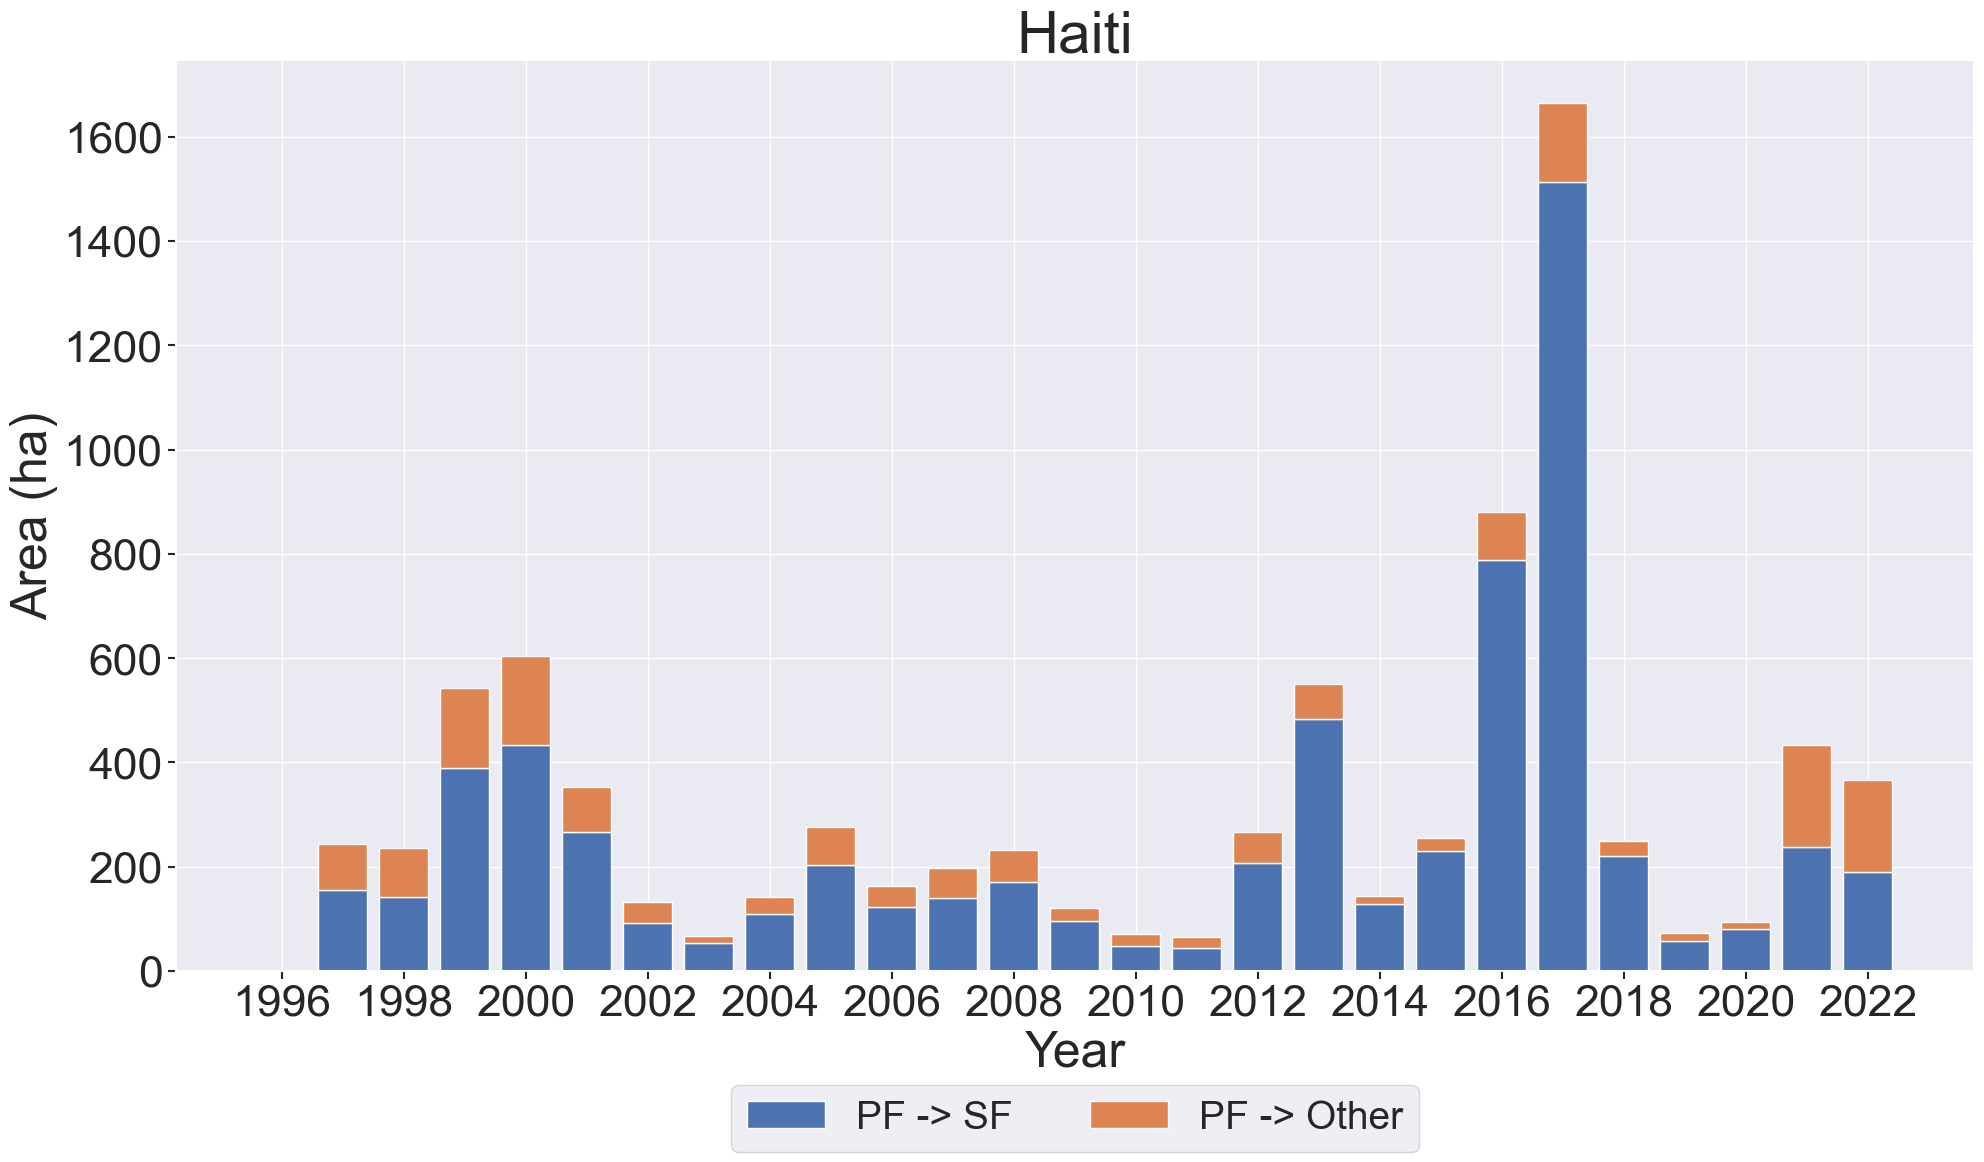

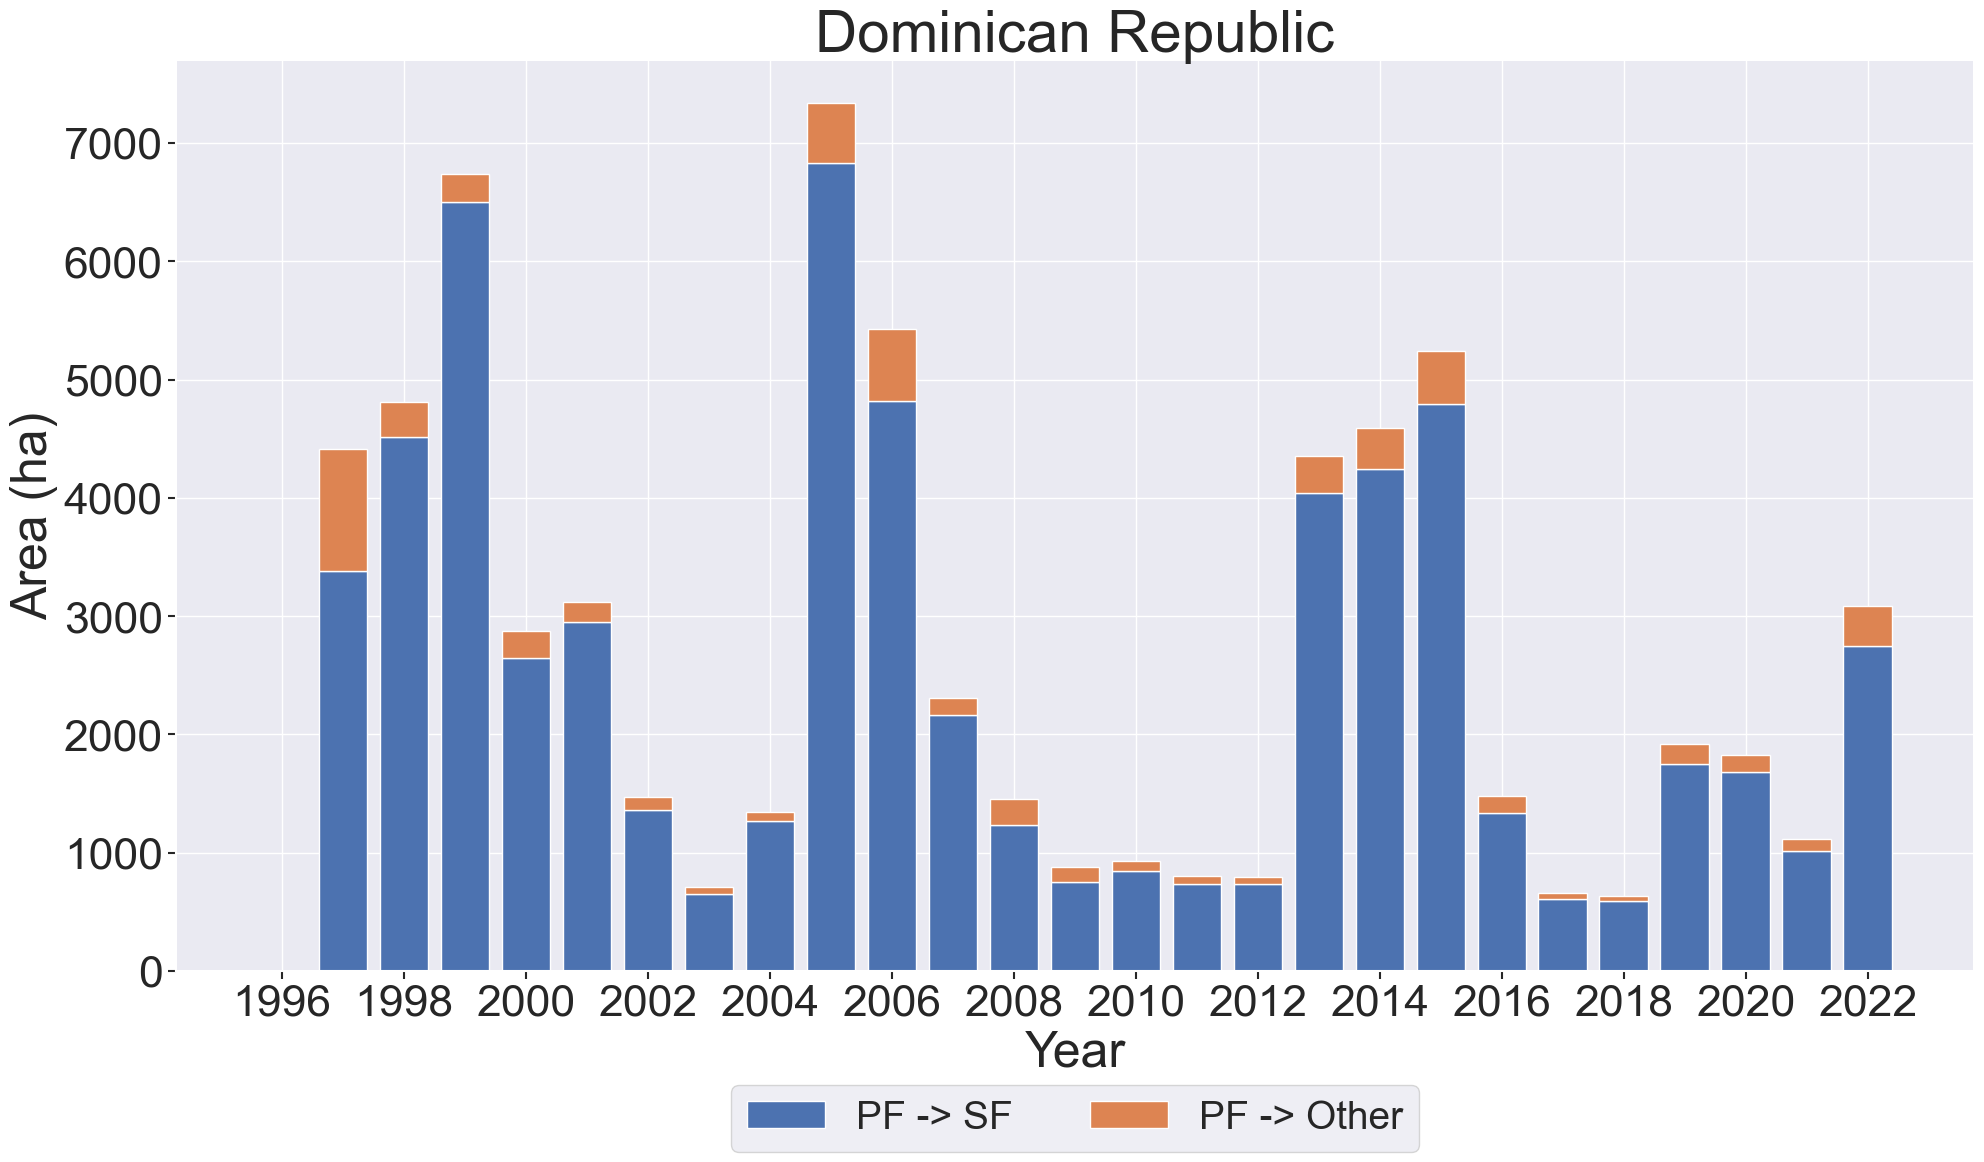

In [2]:
pwd = os.getcwd()
rootpath = os.path.abspath(os.path.join(pwd, '..'))

# np.set_printoptions(precision=4, suppress=True)

country_flag = 'haiti'
df_pf_lc_count_haiti = get_conversion_info(country_flag, rootpath)

country_flag = 'dr'
df_pf_lc_count_dr = get_conversion_info(country_flag, rootpath)

# plot_pf_annual_conversion_stacked(df_pf_lc_count_haiti, plot_type='accumulate',
#                                   x_label='Year', y_label='Area (ha)', title='Haiti')
#
# plot_pf_annual_conversion_stacked(df_pf_lc_count_dr, plot_type='accumulate',
#                                   x_label='Year', y_label='Area (ha)', title='Dominican Republic')

plot_pf_annual_conversion_stacked(df_pf_lc_count_haiti, plot_type='single',
                                  x_label='Year', y_label='Area (ha)', title='Haiti',)

plot_pf_annual_conversion_stacked(df_pf_lc_count_dr, plot_type='single',
                                  x_label='Year', y_label='Area (ha)', title='Dominican Republic',)